In [1]:
import xgboost as xgb
import pandas as pd
import src.train_utils as T
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # Try 'ggplot' as an alternative
# 1) show every column
pd.set_option('display.max_columns', None)

# 2) disable automatic expansion/wrapping
pd.set_option('display.expand_frame_repr', False)

# 3) bump the console width way up (or to None for ‘no limit’)
pd.set_option('display.width', None)



In [2]:
ds = xr.open_dataset('../datasets/exp_3_ds.nc')
mask = ds.time.dt.year < 2022
ds_excl_2022 = ds.sel(time=mask)

for size in range(3, 9+1, 2):
  ds_excl_2022[f'frp_avg_{size}x{size}'] = (
      ds_excl_2022['frp_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .mean()
  )

for size in range(3, 9+1, 2):
  ds_excl_2022[f'frp_max_{size}x{size}'] = (
      ds_excl_2022['frp_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .max()
  )

# 1) Compute rolling‐sum over each square window
cumulative_sums = {}  # will hold the rolling sum for each odd size
for size in range(3, 10, 2):  # 3, 5, 7, 9
    rolling_name = f'frp_sum_{size}x{size}'
    # rolling().sum() gives the sum over a size×size square (centered)
    ds_excl_2022[rolling_name] = (
        ds_excl_2022['frp_t']
          .rolling(i=size, j=size, center=True, min_periods=1)
          .sum()
    )
    cumulative_sums[size] = ds_excl_2022[rolling_name]

# 2) Subtract to get the “ring” (concentric buffer) between each size and the next‐smaller size
previous_size = None
for size in sorted(cumulative_sums.keys()):  # will iterate 3, 5, 7, 9 in order
    ring_name = f'frp_buffer_sum_{size}x{size}'
    if previous_size is None:
        # For size=3, there is no smaller ring to subtract, so the ring=full 3×3 sum
        ds_excl_2022[ring_name] = cumulative_sums[size]
    else:
        smaller_sum = cumulative_sums[previous_size]
        larger_sum  = cumulative_sums[size]
        # ring = sum over size×size minus sum over previous_size×previous_size
        ds_excl_2022[ring_name] = larger_sum - smaller_sum

    previous_size = size


# 4. Convert to DataFrame
train_df = ds_excl_2022.to_dataframe().reset_index()

In [66]:
train_df

,time,i,j,pm25_t,u_wind_t,v_wind_t,dew_temp_t,temp_t,surf_pressure_t,precip_t,frp_t,elevation_t,delta_pm25_t+1,delta_pm25_t,r_humidity_t,delta_pm25_t-1,delta_pm25_t-2,delta_pm25_t-3,delta_pm25_avg_3x3,delta_pm25_avg_5x5,delta_pm25_avg_7x7,delta_pm25_avg_9x9,frp_avg_3x3,frp_avg_5x5,frp_avg_7x7,frp_avg_9x9,frp_max_3x3,frp_max_5x5,frp_max_7x7,frp_max_9x9,frp_sum_3x3,frp_sum_5x5,frp_sum_7x7,frp_sum_9x9,frp_buffer_sum_3x3,frp_buffer_sum_5x5,frp_buffer_sum_7x7,frp_buffer_sum_9x9
0,2018-07-08,0,0,9.513633,1.040234,0.047216,291.942383,293.100189,85344.046875,1.115932e-02,0.0,1360.0,-0.491020,0.556278,98.281067,0.038002,0.601407,0.302968,0.789314,0.734057,0.640796,0.702518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-07-08,0,1,8.694135,0.926424,0.103043,292.972748,294.421875,87667.421875,1.054819e-02,0.0,1189.0,0.339427,0.060918,97.862534,1.064866,-1.001619,0.522349,0.631020,0.626528,0.657130,0.674091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-07-08,0,2,8.702046,0.784416,0.177018,293.667633,295.682129,89480.257812,9.948850e-03,0.0,975.0,0.625493,0.058055,97.051796,0.587489,-1.125940,0.973524,0.349193,0.602640,0.585718,0.532589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-07-08,0,3,8.956724,0.609245,0.260147,293.460449,295.622559,89063.468750,9.994119e-03,0.0,1005.0,0.176971,0.167542,96.837585,0.669046,-0.095932,-0.419762,0.292146,0.400938,0.429089,0.381801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-07-08,0,4,8.738454,0.311515,0.377131,293.645172,295.106354,88635.007812,1.240605e-02,0.0,1059.0,0.251034,0.208978,97.850403,0.311488,-0.186723,0.275500,0.179783,0.147805,0.167027,0.236561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2410315,2021-12-31,43,39,19.179289,-2.037924,-0.773922,285.754028,292.923798,93622.000000,8.523463e-07,0.0,870.0,3.251724,-0.818115,89.703644,-0.246047,1.876458,-3.444041,-0.360418,-0.118820,0.219062,0.310993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2410316,2021-12-31,43,40,19.785183,-1.737936,-0.684505,286.360718,292.731842,95092.710938,8.523463e-07,0.0,673.0,3.448175,0.615328,90.802773,-0.844317,2.134015,-4.559459,0.255882,0.625071,0.679208,0.541765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2410317,2021-12-31,43,41,19.760014,-1.432130,-0.599300,286.689514,292.943512,95813.546875,8.523463e-07,0.0,819.0,2.571398,0.732499,90.972664,-1.900846,3.102393,-5.963127,1.370712,1.260495,0.994243,0.738863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2410318,2021-12-31,43,42,21.715679,-1.049460,-0.781592,287.109741,293.839081,97267.125000,8.523463e-07,0.0,332.0,-0.948131,2.498683,90.343513,-2.307787,3.217414,-4.070193,1.816282,1.642737,1.325162,1.049587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"avg_{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"frp_avg_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                              experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
3            avg_3x3 + avg_5x5 + avg_7x7          25   4.259234  2.890477     1.635680     4.811951     5.014915     8.429635    13.021328     1.999661     0.907189     0.989143     1.820528      3.962305
4  avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9          26   4.262029  2.887693     1.639777     4.830130     5.039243     8.398254    13.068495     2.004410     0.902601     0.987010     1.814540      3.935828
1                                avg_3x3          23   4.285366  2.899083     1.623918     4.930042     5.058410     8.477091    13.073864     2.013985     0.904917     0.987274     1.825857      3.958304
2                      avg_3x3 + avg_5x5          24   4.291265  2.905493     1.631890     4.951220     5.038312     8.452093    13.171988     1.999304     0.906848     0.986724   

                           experiment  mean_rmse
                                 base      4.313
                    avg_3x3 + avg_5x5      4.291
                              avg_3x3      4.285
avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9      4.262
          avg_3x3 + avg_5x5 + avg_7x7      4.259


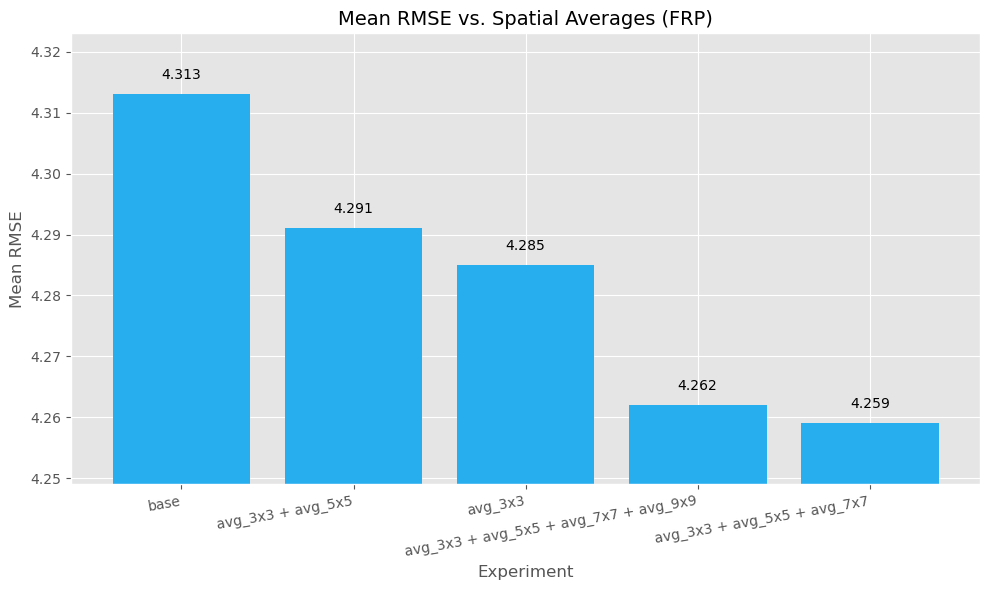

In [9]:
df = results
# Sort by mean_rmse ascending
df_sorted = df.sort_values("mean_rmse", ascending=False)

# Display the sorted DataFrame (experiment and mean_rmse)
display_df = df_sorted[["experiment", "mean_rmse"]].copy()
display_df["mean_rmse"] = display_df["mean_rmse"].round(3)

# Print the table to console
print(display_df.to_string(index=False))

# Create a bar chart of mean RMSE values, sorted
plt.figure(figsize=(10, 6))
bars = plt.bar(display_df["experiment"], display_df["mean_rmse"], color='#27aeef')
plt.ylim(display_df["mean_rmse"].min() - 0.01, display_df["mean_rmse"].max() + 0.01)
plt.xticks(rotation=10, ha="right")
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Mean RMSE", fontsize=12)

# Annotate each bar with its exact mean value
for bar, mean in zip(bars, display_df["mean_rmse"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 0.002, f"{mean:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Mean RMSE vs. Spatial Averages (FRP)", fontsize=14)

plt.tight_layout()
plt.show()


In [10]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"max{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"frp_max_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max3x3 + max5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max3x3 + max5x5 + max7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max3x3 + max5x5 + max7x7 + max9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                          experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
4  max3x3 + max5x5 + max7x7 + max9x9          26   4.258318  2.886747     1.619558     4.894071     5.022154     8.418129    12.966797     2.007437     0.904506     0.983318     1.821194      3.946011
2                    max3x3 + max5x5          24   4.261239  2.890739     1.632358     4.803957     5.035296     8.441336    13.017299     1.998611     0.907871     0.987392     1.818513      3.969760
3           max3x3 + max5x5 + max7x7          25   4.272053  2.895055     1.623868     4.872813     5.052354     8.437663    13.066892     2.000197     0.907319     0.985565     1.824509      3.949346
1                             max3x3          23   4.276665  2.898092     1.640860     4.859802     5.076661     8.448623    13.050534     2.021817     0.909932     0.988047     1.822856      3.94

                       experiment  mean_rmse
                             base      4.313
                           max3x3      4.277
         max3x3 + max5x5 + max7x7      4.272
                  max3x3 + max5x5      4.261
max3x3 + max5x5 + max7x7 + max9x9      4.258


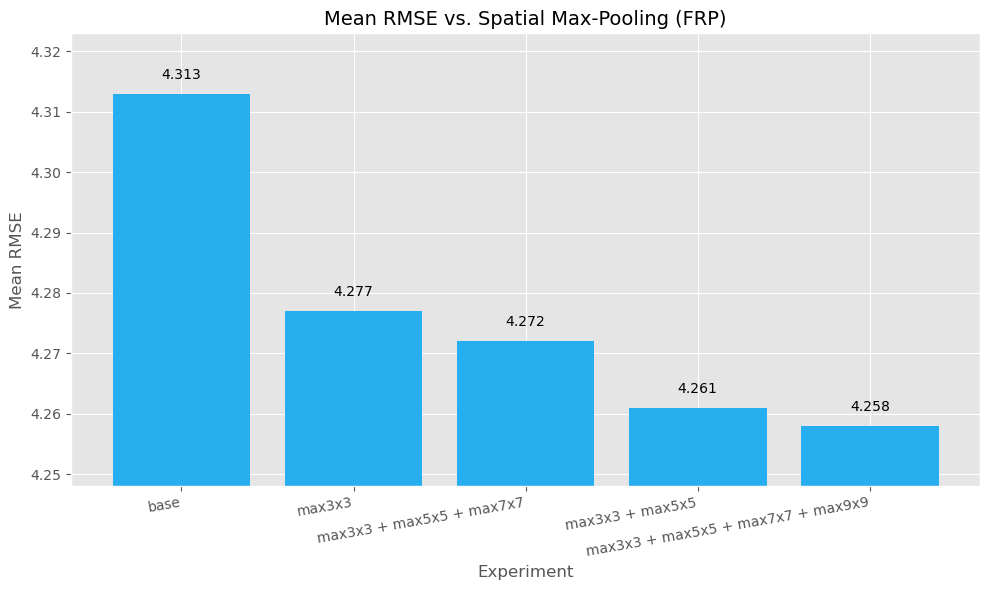

In [11]:
df = results
# Sort by mean_rmse ascending
df_sorted = df.sort_values("mean_rmse", ascending=False)

# Display the sorted DataFrame (experiment and mean_rmse)
display_df = df_sorted[["experiment", "mean_rmse"]].copy()
display_df["mean_rmse"] = display_df["mean_rmse"].round(3)

# Print the table to console
print(display_df.to_string(index=False))

# Create a bar chart of mean RMSE values, sorted
plt.figure(figsize=(10, 6))
bars = plt.bar(display_df["experiment"], display_df["mean_rmse"], color='#27aeef')
plt.ylim(display_df["mean_rmse"].min() - 0.01, display_df["mean_rmse"].max() + 0.01)
plt.xticks(rotation=10, ha="right")
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Mean RMSE", fontsize=12)

# Annotate each bar with its exact mean value
for bar, mean in zip(bars, display_df["mean_rmse"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 0.002, f"{mean:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Mean RMSE vs. Spatial Max-Pooling (FRP)", fontsize=14)

plt.tight_layout()
plt.show()


In [12]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"sum{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"frp_sum_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: sum3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: sum3x3 + sum5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: sum3x3 + sum5x5 + sum7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: sum3x3 + sum5x5 + sum7x7 + sum9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                          experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
4  sum3x3 + sum5x5 + sum7x7 + sum9x9          26   4.270850  2.893101     1.630089     4.862307     5.017567     8.398998    13.143106     1.994717     0.902780     0.983733     1.818362      3.956846
2                    sum3x3 + sum5x5          24   4.273718  2.897256     1.627314     4.862631     5.036919     8.455885    13.071354     1.999140     0.905688     0.987080     1.822250      3.968919
3           sum3x3 + sum5x5 + sum7x7          25   4.279270  2.900195     1.628970     4.817482     5.046863     8.423739    13.208253     1.992089     0.906385     0.988548     1.819179      3.961191
1                             sum3x3          23   4.310227  2.911272     1.627161     4.969839     5.079873     8.459857    13.284160     2.006002     0.907021     0.986174     1.827129      3.95

In [13]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}
feature_experiments = [('base', base)] + [
    (
        " + ".join(f"buffer_sum_{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"frp_buffer_sum_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: buffer_sum_3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: buffer_sum_3x3 + buffer_sum_5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: buffer_sum_3x3 + buffer_sum_5x5 + buffer_sum_7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: buffer_sum_3x3 + buffer_sum_5x5 + buffer_sum_7x7 + buffer_sum_9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                                          experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
3   buffer_sum_3x3 + buffer_sum_5x5 + buffer_sum_7x7          25   4.258817  2.887679     1.633315     4.794489     5.035571     8.430594    13.039039     2.000343     0.903410     0.986378     1.823798      3.941233
4  buffer_sum_3x3 + buffer_sum_5x5 + buffer_sum_7...          26   4.275285  2.892911     1.640941     4.868231     5.030118     8.424077    13.153977     1.993225     0.905726     0.986803     1.817711      3.932040
2                    buffer_sum_3x3 + buffer_sum_5x5          24   4.276300  2.896947     1.636727     4.830444     5.052329     8.436886    13.129902     2.009956     0.908729     0.986476     1.819960      3.951592
1                                     buffer_sum_3x3          23   4.310227  2.911272     1.627161     4.969839     5.079873     8.4

In [7]:
train_df

,time,i,j,pm25_t,u_wind_t,v_wind_t,dew_temp_t,temp_t,precip_t,frp_t,elevation_t,delta_pm25_t+1,delta_pm25_t,delta_pm25_ma2,delta_pm25_ma3,delta_pm25_ma4,delta_pm25_ma5,delta_pm25_ma6,delta_pm25_ma7,delta_pm25_ma8,delta_pm25_ma9,delta_pm25_ma10,delta_pm25_ma11,frp_avg_3x3,frp_avg_5x5,frp_avg_7x7,frp_avg_9x9,frp_max_3x3,frp_max_5x5,frp_max_7x7,frp_max_9x9
0,2018-07-05,0,0,8.317946,1.432791,0.080936,291.415344,295.229156,3.422684e-03,0.0,1360.0,0.601407,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.302968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-07-05,0,1,8.569970,1.296195,0.262333,292.346069,296.649719,2.399749e-03,0.0,1189.0,-1.001619,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.522349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-07-05,0,2,9.182443,1.141206,0.467207,293.259827,297.897217,1.262760e-03,0.0,975.0,-1.125940,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.973524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-07-05,0,3,8.216068,0.974295,0.648889,292.745239,297.833649,4.316330e-04,0.0,1005.0,-0.095932,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,-0.419762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-07-05,0,4,8.404712,0.763805,0.747847,292.605591,297.400787,7.097780e-04,0.0,1059.0,-0.186723,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.275500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416123,2021-12-31,43,39,19.179289,-2.037924,-0.773922,285.754028,292.923798,8.523463e-07,0.0,870.0,3.251724,-0.818115,-0.532081,0.270766,-0.657936,-2.088362,-0.969343,-1.865484,-0.728660,-0.601386,-0.628976,-0.725798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2416124,2021-12-31,43,40,19.785183,-1.737936,-0.684505,286.360718,292.731842,8.523463e-07,0.0,673.0,3.448175,0.615328,-0.114494,0.635009,-0.663608,-1.448466,-1.106534,-1.867256,-0.625299,-0.622077,-0.557387,-0.601193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2416125,2021-12-31,43,41,19.760014,-1.432130,-0.599300,286.689514,292.943512,8.523463e-07,0.0,819.0,2.571398,0.732499,-0.584174,0.644682,-1.007270,-1.214007,-1.029082,-1.679903,-0.697507,-0.613327,-0.622516,-0.812522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2416126,2021-12-31,43,42,21.715679,-1.049460,-0.781592,287.109741,293.839081,8.523463e-07,0.0,332.0,-0.948131,2.498683,0.095448,1.136103,-0.165471,-0.950935,-1.393273,-1.674091,-0.990986,-1.107381,-0.809128,-0.952699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']

base += ['delta_pm25_avg_3x3', 'delta_pm25_avg_5x5', 'delta_pm25_avg_7x7', 'delta_pm25_avg_9x9']

base += ['pm25_avg_3x3', 'pm25_avg_5x5', 'pm25_avg_7x7', 'pm25_avg_9x9']

params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

frp_max = ['frp_max_3x3', 'frp_max_5x5', 'frp_max_7x7', 'frp_max_9x9']

frp_sum = ['frp_buffer_sum_3x3', 'frp_buffer_sum_5x5', 'frp_buffer_sum_7x7', 'frp_buffer_sum_9x9']


feature_experiments = [('base', base)] + [
    ('base + max', base + frp_max),
    ('base + sum', base + frp_sum),
    ('base + max + sum', base + frp_max + frp_sum)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/4 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + max


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + sum


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + max + sum


  0%|          | 0/10 [00:00<?, ?it/s]

         experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
3  base + max + sum          30   4.248382  2.882070     1.635246     4.808600     5.038874     8.413009    12.945456     1.995112     0.908033     0.986864     1.819594      3.933036
1        base + max          26   4.258318  2.886747     1.619558     4.894071     5.022154     8.418129    12.966797     2.007437     0.904506     0.983318     1.821194      3.946011
2        base + sum          26   4.275285  2.892911     1.640941     4.868231     5.030118     8.424077    13.153977     1.993225     0.905726     0.986803     1.817711      3.932040
0              base          22   4.313308  2.916679     1.632187     4.948447     5.087876     8.511748    13.256515     2.006051     0.907929     0.989286     1.818663      3.974378


In [16]:
for size in range(3, 9+1, 2):
  ds[f'frp_max_{size}x{size}'] = (
      ds['frp_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .max()
  )

cumulative_sums = {}  # will hold the rolling sum for each odd size
for size in range(3, 10, 2):  # 3, 5, 7, 9
    rolling_name = f'frp_sum_{size}x{size}'
    # rolling().sum() gives the sum over a size×size square (centered)
    ds[rolling_name] = (
        ds['frp_t']
          .rolling(i=size, j=size, center=True, min_periods=1)
          .sum()
    )
    cumulative_sums[size] = ds[rolling_name]

# 2) Subtract to get the “ring” (concentric buffer) between each size and the next‐smaller size
previous_size = None
for size in sorted(cumulative_sums.keys()):  # will iterate 3, 5, 7, 9 in order
    ring_name = f'frp_buffer_sum_{size}x{size}'
    if previous_size is None:
        # For size=3, there is no smaller ring to subtract, so the ring=full 3×3 sum
        ds[ring_name] = cumulative_sums[size]
    else:
        smaller_sum = cumulative_sums[previous_size]
        larger_sum  = cumulative_sums[size]
        # ring = sum over size×size minus sum over previous_size×previous_size
        ds[ring_name] = larger_sum - smaller_sum

    previous_size = size

ds.to_netcdf(
    "exp_4_ds.nc",
    format="NETCDF4",       # HDF5-backed NetCDF
    engine="netcdf4",      # or "netcdf4" if you have that
    encoding={
        var: {
            "zlib": True,
            "complevel": 4,
        }
        for var in ds.data_vars
    }
)